# plant-seedlings-classification
### create validation data
#### Creating dataset

In [13]:
import torchvision
import torch

In [28]:
import os
import glob
import shutil
import random
from tqdm import tqdm


def create_validation_data(trn_dir, val_dir, split=0.1):
    if not os.path.exists(val_dir):
        os.mkdir(val_dir)
        
    train_ds = glob.glob(trn_dir + '/*/*.png')
    print(len(train_ds))
    
    valid_sz = int(split * len(train_ds)) if split < 1.0 else split 
    
    valid_ds = random.sample(train_ds, valid_sz)
    print(len(valid_ds))

In [39]:
trn_dir = '/Users/mahrokh/Desktop/plant-seedlings-classification/train'
val_dir = '/Users/mahrokh/Desktop/plant-seedlings-classification/val'

create_validation_data(trn_dir, val_dir, split=0.1)

4750
475


## libraries 

In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [31]:
use_gpu

False

# Data
- train: learning the parameters of the model.
- valid: learning hyper-parameters.
- test
- development

In [32]:
sz = 224
batch_size = 16

In [34]:
trn_fnames = glob.glob(f'{trn_dir}/*/*')
trn_fnames[:5]

['/Users/mahrokh/Desktop/plant-seedlings-classification/train/Cleavers/6a4ef17c2.png',
 '/Users/mahrokh/Desktop/plant-seedlings-classification/train/Cleavers/0515bc601.png',
 '/Users/mahrokh/Desktop/plant-seedlings-classification/train/Cleavers/0ac327873.png',
 '/Users/mahrokh/Desktop/plant-seedlings-classification/train/Cleavers/94f82e916.png',
 '/Users/mahrokh/Desktop/plant-seedlings-classification/train/Cleavers/2c5c4d127.png']

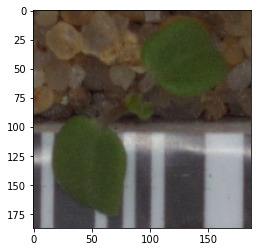

In [35]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

# create validation folder

In [62]:
className = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen'
                 , 'Loose Silky-bent', 'Maize', 'Scentless Mayweed','Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

train_dirr = '/Users/mahrokh/Desktop/plant-seedlings-classification/train/'  
val_dirr = '/Users/mahrokh/Desktop/plant-seedlings-classification/val/'


for i in range(len(className)):
    source = f'{train_dirr}{className[i]}'
    dest = f'{val_dirr}{className[i]}'
    
    files = os.listdir(source)
    no_of_files = len(files) // 5
    
    for file_name in random.sample(files, no_of_files):
        shutil.move(os.path.join(source, file_name), dest)

    

# transformation and making Dataset

In [63]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [64]:
len(train_ds), len(valid_ds)

(3154, 877)

In [65]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

In [69]:
DATA_DIR = '/Users/mahrokh/Desktop/plant-seedlings-classification/'


# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}val', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 3154
Valid size: 877 (0.22)


In [77]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=12)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [82]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))

Epoch [ 1/10], Step [ 50/197], Loss: 0.9284
Epoch [ 1/10], Step [100/197], Loss: 0.7298
Epoch [ 1/10], Step [150/197], Loss: 0.5487
Epoch [ 2/10], Step [ 50/197], Loss: 0.1803
Epoch [ 2/10], Step [100/197], Loss: 0.3179
Epoch [ 2/10], Step [150/197], Loss: 0.2487
Epoch [ 3/10], Step [ 50/197], Loss: 0.1564
Epoch [ 3/10], Step [100/197], Loss: 0.1771
Epoch [ 3/10], Step [150/197], Loss: 0.1441
Epoch [ 4/10], Step [ 50/197], Loss: 0.0769
Epoch [ 4/10], Step [100/197], Loss: 0.0154
Epoch [ 4/10], Step [150/197], Loss: 0.0521
Epoch [ 5/10], Step [ 50/197], Loss: 0.0414
Epoch [ 5/10], Step [100/197], Loss: 0.0086
Epoch [ 5/10], Step [150/197], Loss: 0.2351
Epoch [ 6/10], Step [ 50/197], Loss: 0.0023
Epoch [ 6/10], Step [100/197], Loss: 0.0551
Epoch [ 6/10], Step [150/197], Loss: 0.1265
Epoch [ 7/10], Step [ 50/197], Loss: 0.0172
Epoch [ 7/10], Step [100/197], Loss: 0.1072
Epoch [ 7/10], Step [150/197], Loss: 0.0430
Epoch [ 8/10], Step [ 50/197], Loss: 0.0257
Epoch [ 8/10], Step [100/197], L

In [84]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [85]:
evaluate_model(model, train_dl)

/Users/mahrokh/DeepLearning-razavi/lesson-1-catDog/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 99.56


In [86]:
evaluate_model(model, valid_dl)

accuracy: 94.64


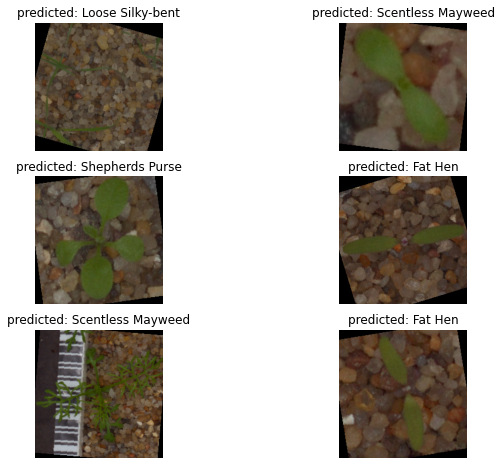

In [87]:
visualize_model(model, train_dl)

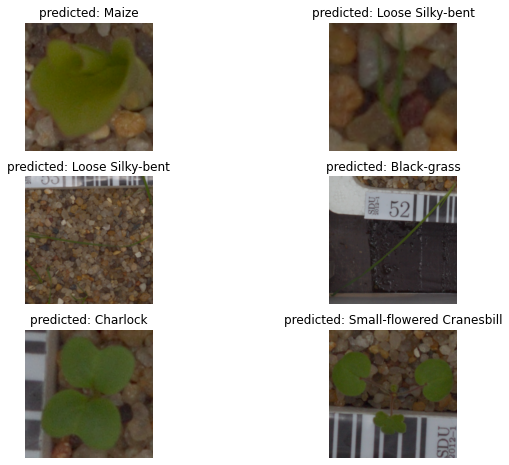

In [88]:
visualize_model(model, valid_dl)

100%|██████████| 55/55 [01:50<00:00,  2.02s/it]


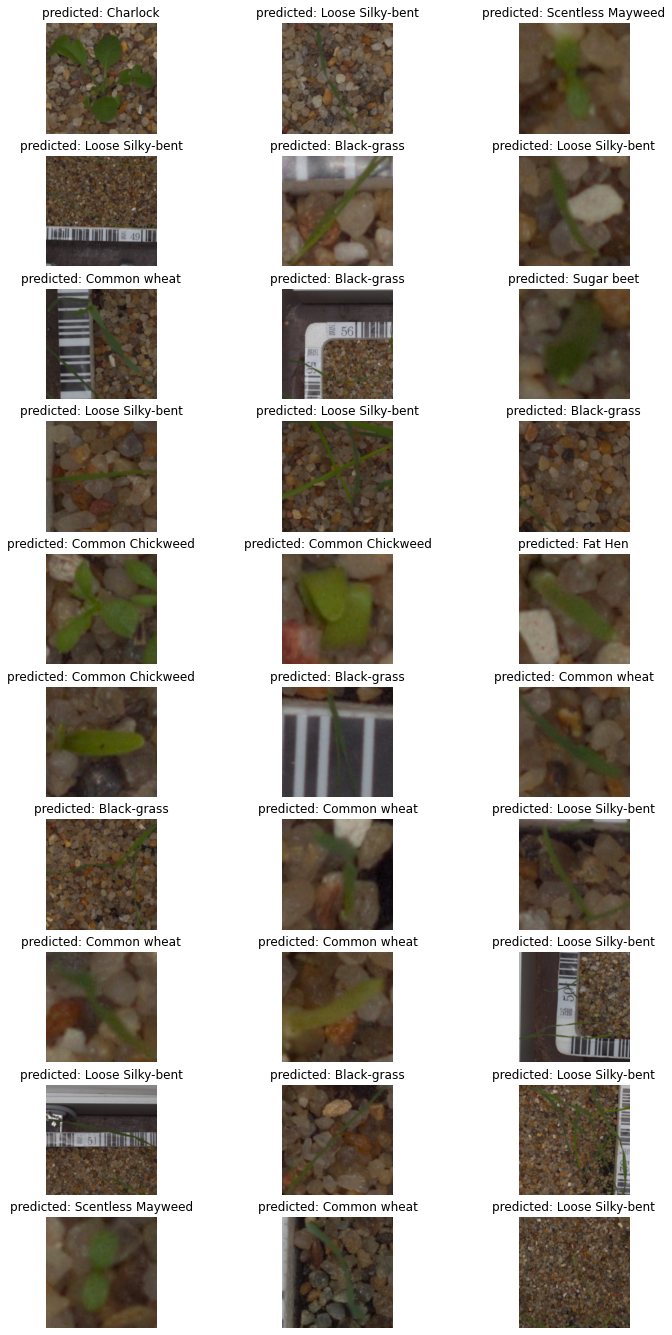

45 images out of 877 were misclassified.


In [89]:
plot_errors(model, valid_dl)

  0%|          | 0/55 [00:00<?, ?it/s]/Users/mahrokh/DeepLearning-razavi/lesson-1-catDog/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 55/55 [01:49<00:00,  1.99s/it]


[[0.8  0.   0.   0.   0.05 0.   0.16 0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.94 0.03 0.   0.   0.   0.   0.   0.03]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.1  0.   0.   0.   0.   0.   0.9  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.03 0.   0.   0.97 0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.03 0.03 0.   0.   0.   0.   0.   0.08 0.86 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.97]]


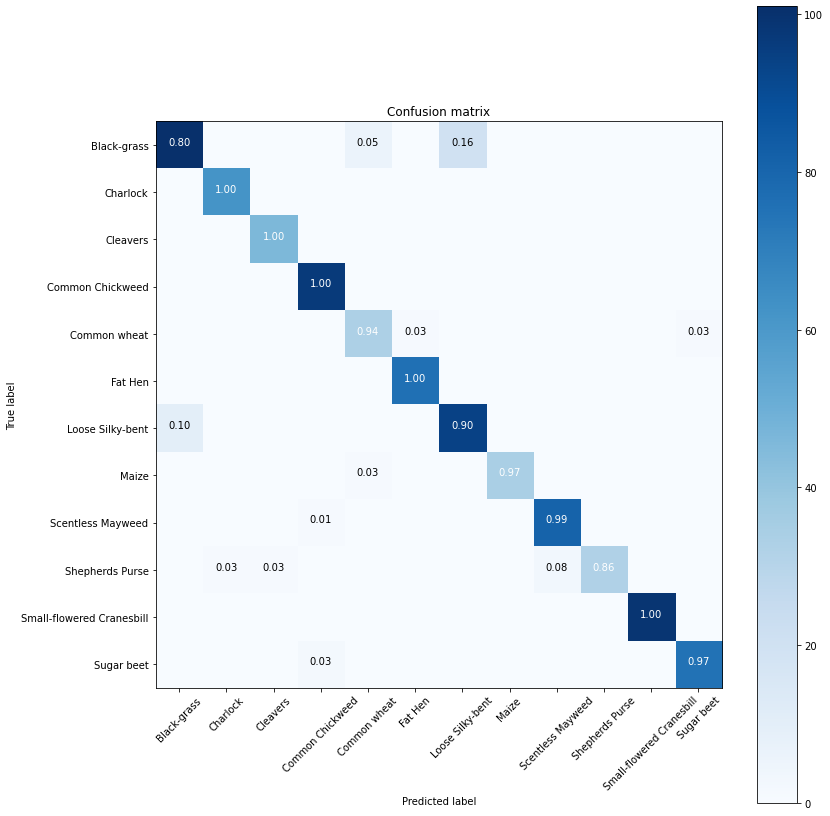

In [91]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12, 12))